[8. 0. 1. 3.]


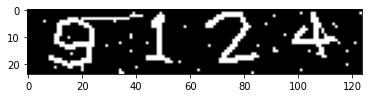

In [1]:
import cv2
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

encoding = '123456789'
root_dir = 'dataset'

img_list = []
label_list = []
for root, dirs, files in os.walk(root_dir):
    if root == root_dir:
        img_list.extend([root+'/'+f for f in files])
        for f in files:
            label = []
            for i in range(4):
                label.append(encoding.index(f[i]))
            label_list.append(label) 
items= []
for i in range(len(img_list)):
    items.append(i)
X = []
y = []
for i in random.sample(items,len(img_list)):
    img = cv2.imread(img_list[i], 0)
    img = tf.keras.preprocessing.image.img_to_array(img)
    X.append(img)
    y.append(label_list[i])
    
X = 1 - np.array(X).astype(float)/255 # invert and scale
y = np.array(y).astype(float)

plt.imshow(X[0], cmap=plt.get_cmap('gray'))
print(y[0])
y = y.T # for traning, shape: (120, 4) => (4, 120)
y = [arr for arr in y]

In [2]:
inputs = tf.keras.Input((24, 124, 1))
x = tf.keras.layers.ZeroPadding2D((50, 0))(inputs)
x = tf.keras.layers.experimental.preprocessing.Resizing(96, 96)(x)
x = tf.keras.layers.Conv2D(3, 3, padding='same')(x)
x = tf.keras.applications.MobileNetV2(input_shape=(96, 96, 3))(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = [tf.keras.layers.Dense(9, name='d1', activation='softmax')(x),\
           tf.keras.layers.Dense(9, name='d2', activation='softmax')(x),\
           tf.keras.layers.Dense(9, name='d3', activation='softmax')(x),\
           tf.keras.layers.Dense(9, name='d4', activation='softmax')(x)]
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 124, 1)] 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 124, 124, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
resizing (Resizing)             (None, 96, 96, 1)    0           zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 3)    30          resizing[0][0]                   
______________________________________________________________________________________________

In [3]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy']
)
batch_size = 32
epochs = 25

In [4]:
history = model.fit(
    X, 
    y,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = 0.2
)

Epoch 1/25
7/7 [==============================] - 7s 411ms/step - loss: 8.7892 - d1_loss: 2.1953 - d2_loss: 2.1995 - d3_loss: 2.1971 - d4_loss: 2.1972 - d1_accuracy: 0.1105 - d2_accuracy: 0.1374 - d3_accuracy: 0.1288 - d4_accuracy: 0.1400 - val_loss: 8.7875 - val_d1_loss: 2.1979 - val_d2_loss: 2.1985 - val_d3_loss: 2.1949 - val_d4_loss: 2.1962 - val_d1_accuracy: 0.1053 - val_d2_accuracy: 0.0877 - val_d3_accuracy: 0.1053 - val_d4_accuracy: 0.1404
Epoch 2/25
7/7 [==============================] - 1s 194ms/step - loss: 8.7595 - d1_loss: 2.1893 - d2_loss: 2.1918 - d3_loss: 2.1886 - d4_loss: 2.1898 - d1_accuracy: 0.2174 - d2_accuracy: 0.1788 - d3_accuracy: 0.2147 - d4_accuracy: 0.2137 - val_loss: 8.7894 - val_d1_loss: 2.1968 - val_d2_loss: 2.1982 - val_d3_loss: 2.1970 - val_d4_loss: 2.1974 - val_d1_accuracy: 0.1053 - val_d2_accuracy: 0.0877 - val_d3_accuracy: 0.1228 - val_d4_accuracy: 0.1579
Epoch 3/25
7/7 [==============================] - 1s 190ms/step - loss: 8.7301 - d1_loss: 2.1792 - d

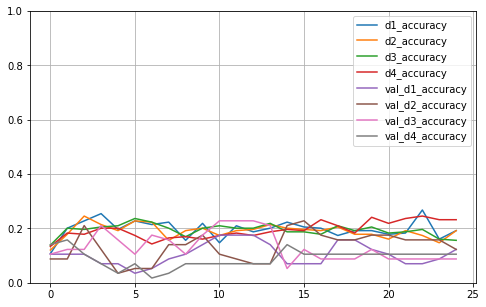

In [5]:
import pandas as pd
def plot_learning_curves(history):
    df = pd.DataFrame(history.history)
    df = df[['d1_accuracy',
             'd2_accuracy',
             'd3_accuracy',
             'd4_accuracy',
             'val_d1_accuracy',
             'val_d2_accuracy',
             'val_d3_accuracy',
             'val_d4_accuracy'
            ]]
    df.plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)

[array([[0.11278274, 0.11137225, 0.12209266, 0.09368828, 0.12367129,
         0.09934798, 0.11764129, 0.10857797, 0.11082556]], dtype=float32),
 array([[0.10831249, 0.09492984, 0.13060503, 0.09045767, 0.11246929,
         0.12035778, 0.12131436, 0.12466347, 0.09689008]], dtype=float32),
 array([[0.12200141, 0.11151544, 0.11204602, 0.12232628, 0.10099783,
         0.10567052, 0.09546502, 0.12544271, 0.10453486]], dtype=float32),
 array([[0.09386612, 0.11406007, 0.10921524, 0.12268606, 0.11348954,
         0.08960528, 0.15059464, 0.09932101, 0.10716207]], dtype=float32)]

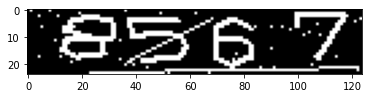

In [6]:
out = model.predict(np.expand_dims(X[-1], 0))
plt.imshow(X[-1], cmap=plt.get_cmap('gray'))
out